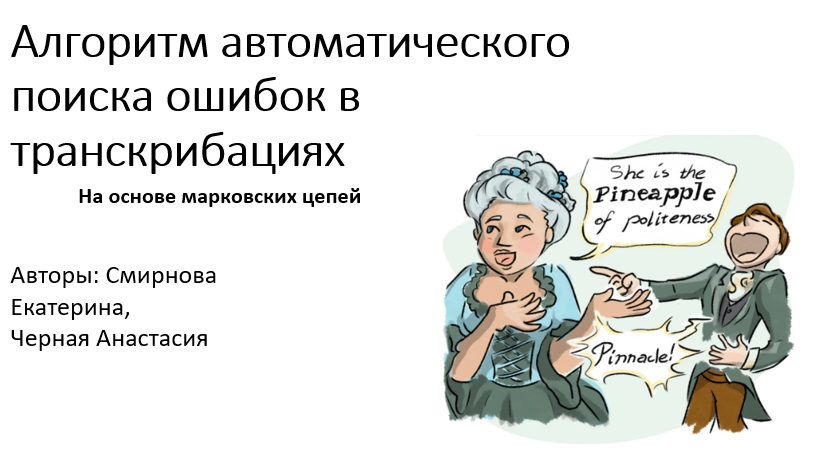

# Алгоритм автоматического поиска ошибок в транскрибациях 
## на основе марковских цепей

## Загрузка библиотек

In [1]:
import pandas as pd
import re

import nltk
from nltk import word_tokenize

from string import punctuation

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

from num2words import num2words
from fuzzywuzzy import fuzz

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score

## Загрузка данных

#### Корпус диалогов для обучения языковой модели
Корпус русскоязычных диалогов, извлеченных из большого корпуса художественной литературы, документалистики и т.д. объемом 130 Мб

[Ссылка на репозиторий с корпусом](https://github.com/Koziev/NLP_Datasets/blob/master/Conversations/Data/dialogues.zip) 

In [47]:
with open('dialogues.txt', encoding='utf-8') as corp:
    corp = corp.read()

#### Корпус со сказками для обучения

[Датасет](https://www.kaggle.com/idoldev/adult-and-child-russian-tales-dataset-with-label) для обучения модели классификации сказок

In [5]:
tales = pd.read_excel('C://Users//18198559//Projects//speech_research//sentiment//датасеты//adult_child_tales.xlsx')

In [6]:
tales.head()

,Tale,Label
0,"Снежно белый снеговик Он не мал и не велик, Сн...",1
1,Снеговик из детской сказки Раскраснелась детво...,1
2,Снежная баба Мы снежную бабу слепили на славу....,1
3,"Ком, комочек и комок Что стоишь и ждёшь, дружо...",1
4,Лепим снеговика Лепит с самого утра Детвора сн...,1


In [7]:
t = list(tales.Tale.values)
t = ' '.join([str(sent) for sent in t])

#### Корпус транскрибаций

In [41]:
trans = pd.read_excel('all_transcripts.xlsx')

In [125]:
trans.head()

,audio_ID,alphacep_transcripts,abk_transcripts
0,NDS_001-f-z.eaf,NaN,азат аллё а потом вот опять заново уже а по по...
1,NDS_002-f-z.eaf,слуга прошла подальше от прошла галлия а этот ...,хорошо да да гулять а я я ульянова задачка у н...
2,NDS_003-f-z.eaf,NaN,например спасибо я назад одна с нами наименее ...
3,NDS_004-m-z.eaf,NaN,я я готова я не пошёл
4,NDS_005-m-z.eaf,NaN,говорите а да манакова


Т.к. транскрибации подкорпуса NDS получились очень плохого качества из-за специфики детской речи, в рамках данного проекта рассмотрим только подкорпуса Pic и Sib. 

Отфильтруем из общего датафрейма нужные нам транскрибации и разберем их по двум датафреймам в заивисмости от модели транскрибатора

In [127]:
trans_alpha = trans.loc[
       (trans.audio_ID.str.contains('Sib')|trans.audio_ID.str.contains('Pic'))&trans.alphacep_transcripts.notnull(),
       ['audio_ID','alphacep_transcripts']
    ]
trans_abk = trans.loc[
       (trans.audio_ID.str.contains('Sib')|trans.audio_ID.str.contains('Pic'))&trans.abk_transcripts.notnull(),
       ['audio_ID','abk_transcripts']
    ]

In [128]:
trans_alpha.head()

,audio_ID,alphacep_transcripts
35,Pic-RUS_01-f_Pr-R.eaf,жилбыл один дяденька по его жены скоро должно ...
38,Pic-RUS_01-f_Ski-T.eaf,генин жизни одного очень увлекающийся спортом ...
39,Pic-RUS_02-f_Pr-R.eaf,однозначным был день рождения мышь решил подар...
42,Pic-RUS_02-f_Ski-T.eaf,этот человек встал рано утром позавтракал а по...
45,Pic-RUS_03-m_Ski-R.eaf,знакомым мне здесь рассказали одну смешную и п...


In [129]:
trans_abk.head()

,audio_ID,abk_transcripts
35,Pic-RUS_01-f_Pr-R.eaf,жил был один дяденька его жены скоро должно бы...
36,Pic-RUS_01-f_Pr-T.eaf,товарищ тут с ним случилось проблема у его жен...
37,Pic-RUS_01-f_Ski-R.eaf,жил был один молодой человек это молодой челов...
38,Pic-RUS_01-f_Ski-T.eaf,день жизнь одного точне увлекающейся спорту му...
39,Pic-RUS_02-f_Pr-R.eaf,однозначно был день рождения её муж решил пода...


## Предобработка тренировочных корпусов

#### Корпус диалогов

In [298]:
# посмотрим на корпус диалогов
corp[:1000]

'- Пока, толстуха!\n- Пока, малышка!\n\n- Этому надо положить конец,\n- Это не жизнь!\n\n- А ты не помолчишь?\n- Замолчу, когда захочу.\n\n- А ты не помолчишь?\n- Замолчу, когда захочу.\n- Ну так не молчи.\n\n- Это зависит!\n- Будет сегодня хорошая погода, Ганьярд?\n\n- Это зависит!\n- Будет сегодня хорошая погода, Ганьярд?\n- Это зависит!\n\n- Это твоей жене пришло в голову. Значит, тебе и платить.\n- Старина!\n\n- Сделай мне одолжение и сейчас же рассорься с ее мужем!\n- Вот напасть!\n\n- Знаешь, если моя разозлит меня, я ей задам.\n- Тише!\n\n- Стой,\n- Что они там делают?\n\n- Стой,\n- Что они там делают?\n- Ну и ну!\n\n- Пашенька!\n- Чего, мам?\n\n- Радость ты моя, Пашенька!\n- Молодец, Пашка!\n\n- Что, сынонька, что?!\n- Что, Пашенька?\n\n- Андрюха! Да чего же теперь будет?\n- Что надо, Арбузик, то и будет!\n\n- Мне бы Шиповника...\n- Какого еще Шиповника?\n\n- Зачем?\n- Записка ей. С Михельсона. От Андреева.\n- Давай мне!\n\n- Извините, я на минутку.\n- Что, мальчик?\n\n- Вам от

In [12]:
# Функция для предобработки текста корпуса: 
# убираются знаки препинания, 
# приводится к нижнему регистру, 
# цифры заменяются на числительные

def preprocess(text):
    text_proc = text.lower().replace('\n', '')
    text_proc = re.sub(r'ё', r'е', text_proc)
    text_proc = re.sub(r'(([А-я|A-z]+)[0-9]+)', r'\2', text_proc)
    numbers1 = set(re.findall(r'([0-9]+ [0-9]+)', text_proc))
    for numb in numbers1:
        numb = re.sub(r' ', r'', numb)
        numb_word = num2words(int(numb), lang='ru')
        text_proc = text_proc.replace(numb, numb_word)
    numbers2 = set(re.findall(r'([0-9]+)', text_proc))
    for numb in numbers2:
        numb_word = num2words(int(numb), lang='ru')
        text_proc = text_proc.replace(numb, numb_word)
        
    text_proc = re.sub(r'[!"--,.:;?\\;<=>?@\^_`(\{)|(\})]', '', text_proc)            
    
    return text_proc

In [49]:
%%time
#предобработка корпуса диалогов
corp_preproc = preprocess(corp)

Wall time: 1min 29s


In [45]:
# результат предобработки корпуса диалогов
corp_preproc.lstrip()[:1000]

'пока толстуха пока малышка этому надо положить конец это не жизнь а ты не помолчишь замолчу когда захочу а ты не помолчишь замолчу когда захочу ну так не молчи это зависит будет сегодня хорошая погода ганьярд это зависит будет сегодня хорошая погода ганьярд это зависит это твоей жене пришло в голову значит тебе и платить старина сделай мне одолжение и сейчас же рассорься с ее мужем вот напасть знаешь если моя разозлит меня я ей задам тише стой что они там делают стой что они там делают ну и ну пашенька чего мам радость ты моя пашенька молодец пашка что сынонька что что пашенька андрюха да чего же теперь будет что надо арбузик то и будет мне бы шиповника какого еще шиповника зачем записка ей с михельсона от андреева давай мне извините я на минутку что мальчик вам от андрея моего брата спасибо мальчик аа прозвище такое я колючая а шиповник люсик а у меня тоже есть прозвище какое если не секрет аа прозвище такое я колючая а шиповник люсик а у меня тоже есть прозвище какое если не секрет 

#### Корпус сказок

In [300]:
# посмотрим на корпус сказок
t[:1000]

'Снежно белый снеговик Он не мал и не велик, Снежно белый снеговик. У него морковкой нос, Очень любит он мороз, В стужу, он не замерзает. А весна приходит – тает. Что же делать, как же быть? Как его нам сохранить? Может белый холодильник, Для снеговика купить?  Снеговик из детской сказки Раскраснелась детвора - Накатала три шара! Друг на друга их сложили, И ведро нагромоздили. Нос - морковка, уголь - глазки, Снеговик из детской сказки! Руки - ветки, рот - конфета... Пусть стоит теперь до лета!   Снежная баба Мы снежную бабу слепили на славу.  На славу, на славу, себе на забаву. На нас она черными смотрит глазами,  Как будто смеется двумя угольками. Хотя и стоит наша баба с метлой,  Но пусть не покажется вам она злой. Ведро вместо шляпы надели мы ей…  Со снежною бабой игра веселей.  Ком, комочек и комок Что стоишь и ждёшь, дружок: Ком, комочек и комок? Угли — глазки, нос — морковка, И метёлку держишь ловко. Мне прекрасно здесь стоится, В двери Новый год стучится, Дедушка Мороз и вьюга Л

In [13]:
%%time
#предобработка корпуса сказок
tales_preproc = preprocess(t)
tales_preproc = tales_preproc.replace('\xa0', '')

Wall time: 23.8 s


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: Possible set difference at position 3
  from ipykernel import kernelapp as app


In [302]:
# результат предобработки корпуса сказок
tales_preproc[:1000]

'снежно белый снеговик он не мал и не велик снежно белый снеговик у него морковкой нос очень любит он мороз в стужу он не замерзает а весна приходит – тает что же делать как же быть как его нам сохранить может белый холодильник для снеговика купить  снеговик из детской сказки раскраснелась детвора  накатала три шара друг на друга их сложили и ведро нагромоздили нос  морковка уголь  глазки снеговик из детской сказки руки  ветки рот  конфета пусть стоит теперь до лета   снежная баба мы снежную бабу слепили на славу  на славу на славу себе на забаву на нас она черными смотрит глазами  как будто смеется двумя угольками хотя и стоит наша баба с метлой  но пусть не покажется вам она злой ведро вместо шляпы надели мы ей…  со снежною бабой игра веселей  ком комочек и комок что стоишь и ждешь дружок ком комочек и комок угли — глазки нос — морковка и метелку держишь ловко мне прекрасно здесь стоится в двери новый год стучится дедушка мороз и вьюга лепят для меня подругу  лепим снеговика лепит с 

### Токенизация, лемматизация и статистика по корпусам

#### Для корпуса диалогов

In [50]:
# количество токенов
tokens = word_tokenize(corp_preproc)
len(tokens)

12380889

In [139]:
# получение словаря уникальных токенов
vocab = set(tokens)
len(vocab)

315199

In [52]:
%%time
# лемматизация корпуса
lemmas = []
for word in tokens:
    lemma = morph.normal_forms(word)[0]
    lemmas.append(lemma)

Wall time: 1h 20min 57s


In [466]:
lemmas[:10]

['пока',
 'толстуха',
 'пока',
 'малышок',
 'это',
 'надо',
 'положить',
 'конец',
 'это',
 'не']

In [22]:
# количество уникальных лемм
len(set(lemmas))

163536

In [53]:
# сохраняем лемматизированный корпус в файл
with open('corp_lemmas.txt', 'w', encoding='utf-8') as file:
    file = file.write(' '.join(lemmas))

#### Для корпуса сказок

In [303]:
# количество токенов
tokens_t = word_tokenize(tales_preproc)
len(tokens_t)

1883195

In [130]:
# получение словаря уникальных токенов
vocab_t = set(tokens_t)
len(vocab_t)

174321

In [24]:
%%time
# лемматизация корпуса
lemmas_t = []
for word in tokens_t:
    lemma_t = morph.normal_forms(word)[0]
    lemmas_t.append(lemma_t)

Wall time: 11min 51s


In [132]:
# количество уникальных лемм
len(set(lemmas_t))

83051

In [34]:
# сохраняем лемматизированный корпус в файл
with open('tales.txt', 'w', encoding='utf-8') as file:
    file = file.write(' '.join(lemmas_t))

#### Объединяем лемматизированные корпуса

In [54]:
lem_all = lemmas+lemmas_t

In [55]:
#общий объем объединенного корпуса
len(lem_all)

14264084

In [56]:
# количество уникальных лемм
len(set(lem_all))

210379

#### Создание объединенного словаря словоформ

In [140]:
voc = vocab.union(vocab_t)

In [141]:
len(voc)

404110

## Марковская цепь

#### Подсчет условных частот

In [57]:
cfreq_all = nltk.ConditionalFreqDist(nltk.bigrams(lem_all))#для лемматизированного объединенного корпуса 

#### Подсчет условных вероятностей

In [58]:
cprob_all = nltk.ConditionalProbDist(cfreq_all, nltk.MLEProbDist)#для лемматизированного объединенного корпуса

## Объявление функций для нахождения ошибок текста

In [304]:
'''
Функция для предобработки текста транскрибации: замена ё/е, составление биграм
Аргументы:
    text - исследуемый текст
Вывод:
    список биграм текста 
'''

def text_preprocess(text):
    text = text.replace('ё','е')
    
    bigram_vectorizer = CountVectorizer(ngram_range=(2,2),
                                    token_pattern=r'[а-я]+', min_df=1)
    analyze = bigram_vectorizer.build_analyzer()
    bigrams = analyze(text) 
    return bigrams

In [151]:
with open('words_with_hyphen.txt', encoding='utf-8') as file:
    hyphened_words = file.read().split('\n')

In [173]:
'''
Функция для предобработки текста транскрибации: вставка дефиса для случаев "когдато"
Аргументы:
    word - исследуемое слово
    words_with_hyphen - справочник слов с дефисом
Вывод:
    слово с дефисом 
'''

def insert_hyphen(word, words_with_hyphen):
    splits = [(word[:i], word[i:]) for i in range (len(word) - 1)]
    for L, R in splits:
        if L + '-' + R in words_with_hyphen:
            word = L + '-' + R
    return word

In [197]:
'''
Функция для предобработки текста транскрибации: замена случаев "когдато" на слова с дефисом
Аргументы:
    text - исследуемый текст
    words_with_hyphen - справочник слов с дефисом
Вывод:
    скорректированный текст 
'''

def insert_hyphen_in_text(text, words_with_hyphen):
    correct_text = ''
    correct_words = []
    text = text.split()
    for word in text:
        correct_word = insert_hyphen(word, words_with_hyphen)
        if correct_word != word:
            correct_words.append(correct_word)
        correct_text = correct_text + correct_word + ' '
    return correct_text.strip()

In [237]:
'''
Функция для нахождения ошибок транскрибаций

Параметры:
    text - исходный текст для анализа (str)
    model_freq - словарь частот совместной встречаемости, полученный на основе обучающего корпуса (nltk.probability.ConditionalFreqDist)
    model_prob - словарь вероятности совместной встречаемости, полученный на основе обучаюшего корпуса (nltk.probability.ConditionalProbDist)
    lemma - лемматизация слов в биграмах - по умолчанию True (bool)
    threshold - порог для установления "ошибки" транскрибации - по умолчанию 0 (int)

Вывод:
    mistakes - список биграм, в которых есть ошибка транскрибации (list)
    bigrams_prob_dict - словарь, содержащий биграмы, в которых нет ошибки, и вероятности совместной встречаемости слов биграм (dict)
    no_such_word - список биграм, в которых хотя бы одно слово отсутствует в словаре обучающего корпуса (list)

'''

def find_mistakes(text, model_freq, model_prob, lemma = True, threshold = 0):
    mistakes = [] #переменная для хранения "ошибок"
    no_such_word = [] #переменная для хранения биграм, в которых хотя бы одно слово отсутствует в обучающем корпусе
    bigrams_prob_dict = {} #переменная для хранения "правильных" биграм и их вероятностей
    
    TEXT = text_preprocess(text) #список биграм текста
    
    for bigram in TEXT:
        big = bigram.split()
        if lemma == True:
            big = [morph.normal_forms(token)[0] for token in big] #лемматизируем слова в биграмах
    
        if model_freq[big[0]]=={} or model_freq[big[1]]=={}: #проверяем, есть ли слово в нашем тренировочном корпусе
            no_such_word.append(bigram)
            continue
    
        else:
            #считаем ошибкой, если вероятность совместной встречаемости меньше или равна установленному порогу
            if model_prob[big[0]].prob(big[1]) <= threshold: 
                mistakes.append(bigram)
            else:
                bigrams_prob_dict[bigram] = model_prob[big[0]].prob(big[1])
                
    print('\tВсего ошибок: ', len(mistakes), ' из ', len(TEXT))
    print('\tКоличество биграм с отсутствующим в словаре словом: ', len(no_such_word))
    
    return mistakes, bigrams_prob_dict, no_such_word

In [190]:
'''
Функция для нахождения слов-ошибок в биграмах - кандидатах на ошибку

Аргументы:
    mistakes - список биграм-кандидатов на ошибку из рассматриваемого
    bigrams_prob_dict - словарь с "правильными" биграмами того же текста
    
Вывод:
    словарь вида: {`слово-ошибка`: `биграма-кандидат`}
'''

def find_true_mistakes(mistakes, bigrams_prob_dict):
    true_mistakes = {}
    for mist in mistakes:
        for word in mist.split():
            bigs = []
            for key in bigrams_prob_dict:
                bigs += key.split()
            if word in bigs:
                continue
            else:
                if word not in true_mistakes:
                    true_mistakes[word]= mist
    return true_mistakes

In [283]:
'''
Функция для нахождения слов в словаре тренировочного корпуса, схожих исходному по расстоянию Левенштейна

Аргументы:
    vocab - словарь тренировочного корпуса (слова не лемматизированы!)
    true_mistakes - словарь слов-ошибок и их биграм

Вывод:
    словарь вида {`слово-ошибка`: [`список схожих слов`]}
'''


def find_variation(vocab, true_mistakes):
   
    variates = {}
    for mistake in true_mistakes:
        words = []
        for word in vocab:
            
            if fuzz.ratio(mistake, word) > 80: 
                words.append(word)
        variates[mistake] = words
    
    return variates

In [284]:
'''
Функция для поиска ошибок 2-х категорий в тексте транскрибации:
1-я категория - вероятность схожего слова, найденного по расстоянию Левенштейна, в данной биграме выше,чем вероятность исходного слова;
2-я категория - вероятность схожего слова та же;

Аргументы:
    leven_mist - словарь, где ключ - исходное слово-ошибка, значение - список схожих слов по Левенштейну
    true_mistakes - словарь слов-ошибок и их биграм
    cprob_all - модель для подсчета условной вероятности слов в биграме

Вывод:
    first_mistakes - список слов первой категории
    second_mistakes - список слов второй категории
    
'''


def categorize_mistakes(leven_mist, true_mistakes, cprob_all):
    
    first_mistakes = []
    second_mistakes = []
    new_words = []
    
    for key in leven_mist:
        candidates = [morph.normal_forms(cand)[0] for cand in leven_mist[key]]
                      
        pair = ''.join([word for word in true_mistakes[key].split() if word != key])
        pair_lem = morph.normal_forms(pair)[0]
        key_lem = morph.normal_forms(key)[0]
        
        for cand in candidates:
            if cand != key_lem:
                if cprob_all[cand].prob(pair_lem)> 0:
                    first_mistakes.append(key)
                    new_words.append(cand)
                    break
    
        second_mistakes.append(key)
    return first_mistakes, second_mistakes, new_words

## Работа с транскрибациями

#### Корпус транскрибатора alphacep

In [294]:
%%time
trans_alpha['mistakes'] = ''
trans_alpha['bigram_mist'] = ''
trans_alpha['new_words'] = ''
trans_alpha['mistakes_1st_type'] = ''
trans_alpha['mistakes_2nd_type'] = ''
trans_alpha['absent_words'] = ''


for row in trans_alpha.alphacep_transcripts.index:
    print('Обрабатываю ряд ', row)
    text = insert_hyphen_in_text(trans_alpha.alphacep_transcripts[row], hyphened_words)
    mistakes, bigrams_prob_dict, no_such_word = find_mistakes(text, cfreq_all, cprob_all)
    true_mistakes = find_true_mistakes(mistakes, bigrams_prob_dict)
    leven_mist = find_variation(voc, true_mistakes)
    
    first_mistakes, second_mistakes, new_words = categorize_mistakes(leven_mist, true_mistakes, cprob_all)
    
    trans_alpha['mistakes'][row] = ', '.join([key for key in true_mistakes])
    trans_alpha['bigram_mist'][row] = ', '.join([true_mistakes[key] for key in true_mistakes])
    trans_alpha['new_words'][row] =', '.join(new_words)
    trans_alpha['absent_words'][row] = ', '.join(no_such_word)
    trans_alpha['mistakes_1st_type'][row] = ', '.join(first_mistakes)
    trans_alpha['mistakes_2nd_type'][row] = ', '.join(second_mistakes)

Обрабатываю ряд  35
	Всего ошибок:  36  из  147
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  38
	Всего ошибок:  24  из  85
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  39
	Всего ошибок:  16  из  80
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  42
	Всего ошибок:  11  из  67
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  45
	Всего ошибок:  24  из  88
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  46
	Всего ошибок:  18  из  70
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  52
	Всего ошибок:  36  из  128
	Количество биграм с отсутствующим в словаре словом:  2
Обрабатываю ряд  54
	Всего ошибок:  18  из  109
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  55
	Всего ошибок:  7  из  41
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  58
	Всего ошибок:  10  из  61
	Количество биграм с отс

In [475]:
trans_alpha.head()

,audio_ID,alphacep_transcripts,mistakes,mistakes_1st_type,mistakes_2nd_type,absent_words,bigram_mist,new_words
35,Pic-RUS_01-f_Pr-R.eaf,жилбыл один дяденька по его жены скоро должно ...,"плот, ночного, манекен, стоящее, посол, варт, ...","ночного, манекен, наставь, дядечка, маменьку","плот, ночного, манекен, стоящее, посол, варт, ...",,"случится плот, дяденька ночного, то манекен, н...","необычный, манекенщица, настать, дядька, машенька"
38,Pic-RUS_01-f_Ski-T.eaf,генин жизни одного очень увлекающийся спортом ...,"генин, спортом, стал, хочется, партийный, това...","хочется, норг","генин, спортом, стал, хочется, партийный, това...",,"генин жизни, увлекающийся спортом, проснулся с...","хотеть, нога"
39,Pic-RUS_02-f_Pr-R.eaf,однозначным был день рождения мышь решил подар...,"однозначным, мышь, усмотрел, посылала, выбрал","усмотрел, посылала","однозначным, мышь, усмотрел, посылала, выбрал",,"однозначным был, рождения мышь, и усмотрел, в ...","смотреться, послать"
42,Pic-RUS_02-f_Ski-T.eaf,этот человек встал рано утром позавтракал а по...,"наложены, божественного, поранился",,"наложены, божественного, поранился",,"отправился наложены, голову божественного, сил...",
45,Pic-RUS_03-m_Ski-R.eaf,знакомым мне здесь рассказали одну смешную и п...,"нагорных, проснулся, собрался, доскачет, тече,...",,"нагорных, проснулся, собрался, доскачет, тече,...",,"то нагорных, нагорных проснулся, проснулся соб...",


In [307]:
trans_alpha.to_excel('trans_alpha.xlsx')

#### Корпус транскрибатора АБК

In [290]:
trans_abk.head()

,audio_ID,abk_transcripts
35,Pic-RUS_01-f_Pr-R.eaf,жил был один дяденька его жены скоро должно бы...
36,Pic-RUS_01-f_Pr-T.eaf,товарищ тут с ним случилось проблема у его жен...
37,Pic-RUS_01-f_Ski-R.eaf,жил был один молодой человек это молодой челов...
38,Pic-RUS_01-f_Ski-T.eaf,день жизнь одного точне увлекающейся спорту му...
39,Pic-RUS_02-f_Pr-R.eaf,однозначно был день рождения её муж решил пода...


In [295]:
%%time
trans_abk['mistakes'] = ''
trans_abk['bigram_mist'] = ''
trans_abk['new_words'] = ''
trans_abk['mistakes_1st_type'] = ''
trans_abk['mistakes_2nd_type'] = ''
trans_abk['absent_words'] = ''


for row in trans_abk.abk_transcripts.index:
    print('Обрабатываю ряд ', row)
    text = insert_hyphen_in_text(trans_abk.abk_transcripts[row], hyphened_words)
    mistakes, bigrams_prob_dict, no_such_word = find_mistakes(text, cfreq_all, cprob_all)
    true_mistakes = find_true_mistakes(mistakes, bigrams_prob_dict)
    leven_mist = find_variation(voc, true_mistakes)
    
    first_mistakes, second_mistakes, new_words = categorize_mistakes(leven_mist, true_mistakes, cprob_all)
    
    trans_abk['mistakes'][row] = ', '.join([key for key in true_mistakes])
    trans_abk['bigram_mist'][row] = ', '.join([true_mistakes[key] for key in true_mistakes])
    trans_abk['new_words'][row] =', '.join(new_words)
    trans_abk['absent_words'][row] = ', '.join(no_such_word)
    trans_abk['mistakes_1st_type'][row] = ', '.join(first_mistakes)
    trans_abk['mistakes_2nd_type'][row] = ', '.join(second_mistakes)

Обрабатываю ряд  35
	Всего ошибок:  22  из  160
	Количество биграм с отсутствующим в словаре словом:  2
Обрабатываю ряд  36
	Всего ошибок:  27  из  141
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  37
	Всего ошибок:  12  из  101
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  38
	Всего ошибок:  23  из  91
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  39
	Всего ошибок:  13  из  89
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  40
	Всего ошибок:  18  из  144
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  41
	Всего ошибок:  4  из  51
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  42
	Всего ошибок:  12  из  66
	Количество биграм с отсутствующим в словаре словом:  0
Обрабатываю ряд  43
	Всего ошибок:  22  из  119
	Количество биграм с отсутствующим в словаре словом:  2
Обрабатываю ряд  44
	Всего ошибок:  10  из  100
	Количество биграм с 

In [474]:
trans_abk.head()

,audio_ID,abk_transcripts,mistakes,bigram_mist,new_words,mistakes_1st_type,mistakes_2nd_type,absent_words
35,Pic-RUS_01-f_Pr-R.eaf,жил был один дяденька его жены скоро должно бы...,"наверное, маленькую, машинку, снова","таки наверное, купил маленькую, маленькую маши...","маленький, сон","маленькую, снова","наверное, маленькую, машинку, снова","один дячка, дячка заявил"
36,Pic-RUS_01-f_Pr-T.eaf,товарищ тут с ним случилось проблема у его жен...,"присоветует, копать, нотариус, работник, цен, ...","думаю присоветует, присоветует копать, ну нота...","работница, рад","работник, рада","присоветует, копать, нотариус, работник, цен, ...",
37,Pic-RUS_01-f_Ski-R.eaf,жил был один молодой человек это молодой челов...,по,проснулся по,,,по,
38,Pic-RUS_01-f_Ski-T.eaf,день жизнь одного точне увлекающейся спорту му...,"точне, увлекающейся, спорту, спортивный, товар...","одного точне, точне увлекающейся, увлекающейся...","точнее, противный, заря, положить","точне, спортивный, заряд, ложили","точне, увлекающейся, спорту, спортивный, товар...",
39,Pic-RUS_02-f_Pr-R.eaf,однозначно был день рождения её муж решил пода...,"однозначно, грушой, машинку","однозначно был, маленькой грушой, грушой машинку",игрушка,грушой,"однозначно, грушой, машинку",


In [309]:
trans_abk.to_excel('trans_abk.xlsx')

## Оценка алгоритма

### Разметка ошибок и подсчет метрик precision, recall, f1

Для оценки было размечено по 5 транскрипций для каждого транскрибатора 

Выгрузка файлов для разметки

In [421]:
score_alpha = pd.DataFrame({'word':[], 'true':0, 'pred':0})
for ind in [35, 38, 39, 45, 46]:
    score = pd.DataFrame({'word':trans_alpha.alphacep_transcripts[ind].split()})
    score['true'] = 0
    score['pred'] = 0
    score.to_excel(str(ind)+'score_alpha.xlsx')

In [420]:
score_abk = pd.DataFrame({'word':[], 'true':0, 'pred':0})
for ind in [35, 38, 39, 45, 46]:
    score = pd.DataFrame({'word':trans_abk.abk_transcripts[ind].split()})
    score['true'] = 0
    score['pred'] = 0
    score.to_excel(str(ind)+'score_abk.xlsx')

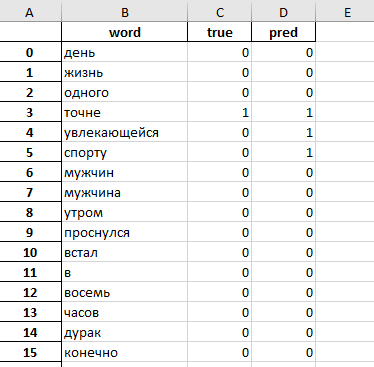

Загрузка размеченных файлов

In [433]:
files_alpha = ['35score_alpha.xlsx','38score_alpha.xlsx','39score_alpha.xlsx','45score_alpha.xlsx','46score_alpha.xlsx']
files_abk = ['35score_abk.xlsx','38score_abk.xlsx','39score_abk.xlsx','45score_abk.xlsx','46score_abk.xlsx']

Формирование значений y_true для транскрибаций alpha

In [438]:
y_true_alpha = []
y_pred_alpha = []
for file in files_alpha:
    df = pd.read_excel(file)
    y_true = list(df.true)
    y_true_alpha+=y_true 
    y_pred = list(df.pred)
    y_pred_alpha += y_pred

Формирование значений y_true для транскрибаций abk

In [442]:
y_true_abk = []
y_pred_abk = []
for file in files_abk:
    df = pd.read_excel(file)
    y_true = list(df.true)
    y_true_abk+=y_true 
    y_pred = list(df.pred)
    y_pred_abk += y_pred

#### Подсчет метрик для всех транскрибаций

In [467]:
print('For all alphacep transcriptions:')
print('\tPrecision: {:0.4f}'.format(precision_score(y_true_alpha, y_pred_alpha)))
print('\tRecall: {:0.4f}'.format(recall_score(y_true_alpha, y_pred_alpha)))
print('\tF1: {:0.4f}'.format(f1_score(y_true_alpha, y_pred_alpha)))

For all alphacep transcriptions:
	Precision: 0.5111
	Recall: 0.6571
	F1: 0.5750


In [468]:
print('For all ABK transcriptions:')
print('\tPrecision: {:0.4f}'.format(precision_score(y_true_abk, y_pred_abk)))
print('\tRecall: {:0.4f}'.format(recall_score(y_true_abk, y_pred_abk)))
print('\tF1: {:0.4f}'.format(f1_score(y_true_abk, y_pred_abk)))

For all ABK transcriptions:
	Precision: 0.3636
	Recall: 0.2927
	F1: 0.3243


#### Подсчет метрик отдельно для кажой транскрибации

In [472]:
for file in files_alpha:
    df = pd.read_excel(file)
    y_true = list(df.true)
    y_pred = list(df.pred)
    print('For file:', file)
    print('\tPrecision: {:0.4f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:0.4f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:0.4f}'.format(f1_score(y_true, y_pred)))

For file: 35score_alpha.xlsx
	Precision: 0.5385
	Recall: 0.5385
	F1: 0.5385
For file: 38score_alpha.xlsx
	Precision: 0.4615
	Recall: 1.0000
	F1: 0.6316
For file: 39score_alpha.xlsx
	Precision: 0.8000
	Recall: 0.6667
	F1: 0.7273
For file: 45score_alpha.xlsx
	Precision: 0.5556
	Recall: 1.0000
	F1: 0.7143
For file: 46score_alpha.xlsx
	Precision: 0.2000
	Recall: 0.2000
	F1: 0.2000


In [471]:
for file in files_abk:
    df = pd.read_excel(file)
    y_true = list(df.true)
    y_pred = list(df.pred)
    print('For file:', file)
    print('\tPrecision: {:0.4f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:0.4f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:0.4f}'.format(f1_score(y_true, y_pred)))

For file: 35score_abk.xlsx
	Precision: 0.5000
	Recall: 0.2000
	F1: 0.2857
For file: 38score_abk.xlsx
	Precision: 0.3636
	Recall: 0.8000
	F1: 0.5000
For file: 39score_abk.xlsx
	Precision: 0.6667
	Recall: 0.1667
	F1: 0.2667
For file: 45score_abk.xlsx
	Precision: 0.3333
	Recall: 0.3333
	F1: 0.3333
For file: 46score_abk.xlsx
	Precision: 0.2222
	Recall: 0.2500
	F1: 0.2353
